# Transformer Demo

## Hand-written digit classification with transformer

In this demo, we will show how to build a transformer for hand-written digit classification. We will use MNIST as the dataset.

In [1]:
import torch
import torchvision


Set random seed

In [2]:
random_seed = 9999
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Load the dataset using Pytorch API. First we load the training set. The training set contains 60000 images and the test set contains 10000 images. 

In [3]:
batch_size_train = 64
batch_size_test = 1000


trainset = torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(trainset))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

60000


In [4]:
testset = torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

print (len(testset))

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=True)

10000


Let's show some example images.

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

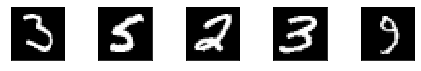

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()

for i in range(5):
  plt.subplot(1,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Let's build a transformer with Pytorch. In transformer, we have multiple encoders and decoders. Each encoder contains one self-attention layer. 

In [8]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import einsum

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super(Attention, self).__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
    

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dim_head = 64, channels=3):
        super(ViT, self).__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x)

        x = self.to_cls_token(x[:, 0])
        return F.log_softmax(self.mlp_head(x))

In [9]:
network = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)

print (network)

ViT(
  (patch_to_embedding): Linear(in_features=49, out_features=64, bias=True)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=64, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): GELU()
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=128, out_features=64, bias=True)
              (4): Dropout(p=0.0, inplace=False

For training the network, we need to specify the optimizer. 

In [10]:
n_epochs = 10
learning_rate = 0.01
momentum = 0.9
log_interval = 10

optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)


In [11]:
train_losses = []
test_losses = []

In [12]:
def train(epoch):
  network.train()
   
  train_loss = 0

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    
    output = network(data)
    
    loss = F.nll_loss(output, target)
    
    train_loss += loss.item()
    
    loss.backward()
    
    optimizer.step()
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    
  
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)
        

In [13]:
def test():
  network.eval()

  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
for epoch in range(1, n_epochs + 1):
  
  train(epoch)
  test()

/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.448005
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.320999
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.301966
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.259480
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.221668
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.049860
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.044194
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.918130
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.997617
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.658419
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.648923
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.624340
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.702447
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.274607
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.225619
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.238003
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.350297
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.171597
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.229294
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.876478
Train Epoch: 1 [12800/60000 (

/Users/yunhui.guo/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2136, Accuracy: 9317/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.166143
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.170023
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.207539
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.124164
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.149177
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.165153
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.084363
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.070156
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.106621
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.242110
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.070600
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.314732
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.181014
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.203988
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.077841
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.210593
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.214318
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.275804
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.162735
Train Epoch: 2 [12160

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.021633
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.109982
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.013154
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.068639
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.019223
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.084777
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.142689
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.036184
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.056862
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.121256
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.051808
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.045809
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.029969
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.237902
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.191801
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.069717
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.073680
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.064156
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.051883
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.060119


Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.056082
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.096403
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.106642
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.028569
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.105226
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.018259
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.005007
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.222852
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.066977
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.153244
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.199600
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.012528
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.090201
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.080314
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.014165
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.175457
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.108448
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.015795
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.053316
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.006785


Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.015867
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.015769
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.051216
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.017013
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.070271
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.098059
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.008578
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.005579
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.197007
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.040089
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.126164
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.058457
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.106497
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.066258
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.039156
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.005066
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.008589
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.022143
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.160768
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.058046


Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.001538
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.057597
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.034617
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.008270
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.002909

Test set: Avg. loss: 0.0697, Accuracy: 9777/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.022430
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.007278
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.074120
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.004321
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.037631
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.032359
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.072809
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.004600
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.012672
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.016719
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.022724
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.045253
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.058900
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.038395
Train Epoch: 9 [896

Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.100362
Train Epoch: 10 [40960/60000 (68%)]	Loss: 0.002011
Train Epoch: 10 [41600/60000 (69%)]	Loss: 0.132875
Train Epoch: 10 [42240/60000 (70%)]	Loss: 0.004553
Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.003240
Train Epoch: 10 [43520/60000 (72%)]	Loss: 0.003622
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.011890
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.082617
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.026348
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.003938
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.074347
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.036093
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.024132
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.001134
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.001710
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.005332
Train Epoch: 10 [50560/60000 (84%)]	Loss: 0.014676
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.004613
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.072011
Train Epoch: 10 [52480/60000 (8

Text(0, 0.5, 'negative log likelihood loss')

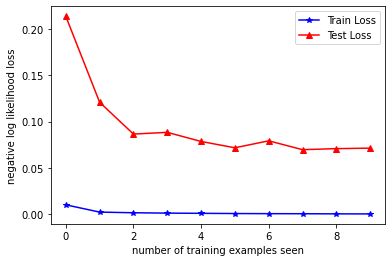

In [15]:
fig = plt.figure()
plt.plot(train_losses, "-*", color='blue')
plt.plot(test_losses, "-^", color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [16]:
with torch.no_grad():
  output = network(example_data)

/usr/local/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:110: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


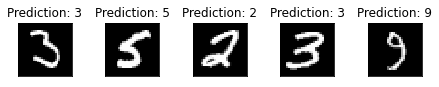

In [17]:
fig = plt.figure()
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
